# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Начнем наш проект

## Подготовка данных

Для начала загрузим все необходимые бибилиотеки (при необходимости будем их добавлять сюда для удобства)

In [2]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import time as tm
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

Прочитаем наш файл с помощью pandas и выведем первые 10 строк

In [3]:
data = pd.read_csv('/datasets/autos.csv')

In [4]:
data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


Посмотрим общую информацию по файлу 

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Итого имеем - у нас 354 369 строк в таблице

Есть ключевой признак (таргет) - Price

Есть также признаки необходимые для обучения модели. Их большинство - но некторые я бы убрал отсюда:
- PostalCode (Для модели нет необходимости делить пользователей на несколько категорий, хотя для общей статистики интересно конечно - лучше обучать обезличенные данные без привязки к пользователям)
- DateCrawled (вообще пока не понимаю что это за пункт - и зачем в модели дата скачивания данных в таблицу из анкеты)

И пару столбцов под вопросом - о дате создания объявления  и дата последнего обновления объявления (на стоимость как мне кажется не влияет или влияет лишь косвенно - если объявление обновляется, то оно актуально)

У числовых столбцов посмотрим корреляцию и мультиколлинеарность для признаков (все ради оптимизации модели)

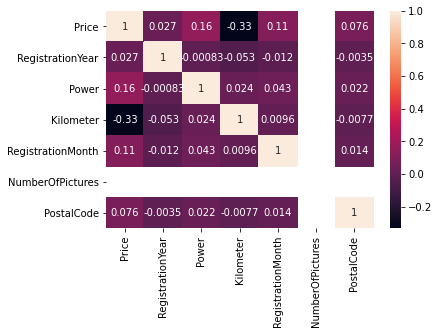

In [6]:
sns.heatmap(data.corr(), annot = True);

Все-таки удалим 6 столбцов - PostalCode, DateCrawled, DateCreated, LastSeen, NumberOfPictures, RegistrationMonth  

Есть мнение что это не совсем правильно, но мы же хотим узнавать стоимость авто в приложении для новых пользователей и эти столбцы с привязкой к датам в прошлом явно лишние

In [7]:
data['DateCrawled'].max()

'2016-04-07 14:36:58'

In [8]:
data['LastSeen'].max()

'2016-04-07 14:58:51'

Аналогично - хорошо, когда теория подтверждается доказательствами

In [9]:
data.drop(columns = ['PostalCode','DateCrawled','DateCreated', 'LastSeen', 'NumberOfPictures', 'RegistrationMonth'],axis = 1, inplace=True)


Проверим все ли получилось

In [10]:
data.columns.tolist()

['Price',
 'VehicleType',
 'RegistrationYear',
 'Gearbox',
 'Power',
 'Model',
 'Kilometer',
 'FuelType',
 'Brand',
 'NotRepaired']

Проверим пропуски по оставшимся столбцам

In [11]:
data.isna().sum()

Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Kilometer               0
FuelType            32895
Brand                   0
NotRepaired         71154
dtype: int64

Итого имеем около 37,5 тысяч пропусков в столбце с типом транспортного средства, по 20 тысяч в столбцах с коробкой передач и моделью, почти 33 тысячи пропусков с типом топлива для автомобиля и 71 тысяча пропусков по ремонту авто (очень важный показатель для нашей задачи)

Поменяю все пропуски на sm - something (что-то)

In [12]:
cols = ['VehicleType', 'Model', 'Gearbox', 'NotRepaired', 'FuelType']

for i in cols:
    data[i] = data[i].fillna('sm')

In [13]:
data.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
NotRepaired         0
dtype: int64

Посмотрим сколько у нас брендов и их общее количество, включая все модели - для общего интереса

In [14]:
r = data.groupby('Brand').agg({'Model':['count']})
print(r)

                Model
                count
Brand                
alfa_romeo       2314
audi            29456
bmw             36914
chevrolet        1754
chrysler         1439
citroen          5148
dacia             900
daewoo            542
daihatsu          806
fiat             9643
ford            25179
honda            2817
hyundai          3587
jaguar            505
jeep              677
kia              2465
lada              225
lancia            471
land_rover        545
mazda            5615
mercedes_benz   32046
mini             3202
mitsubishi       3022
nissan           4941
opel            39931
peugeot         10998
porsche           758
renault         17927
rover             486
saab              526
seat             6907
skoda            5500
smart            5246
sonstige_autos   3374
subaru            762
suzuki           2323
toyota           4606
trabant           589
volkswagen      77013
volvo            3210


Крайне популярны немцы - их большое количество. В лидерах VAG

Проверим выбросы и если есть уберем лишние

<AxesSubplot:>

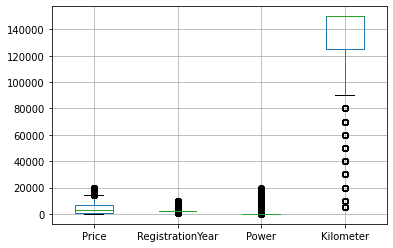

In [15]:
data.boxplot()

Удалим выбросы:

- Уберем мощность двигателя больше 1600 лошадиных сил, у Буггати Широн 1500 (оставим буфер еще в 100 лс - вдруг умельцы смогли как-то проапгрейдить двигатель)

- По нижней границе поставлю 60, буду ориентироваться за ВАЗ 2101 - там 64 лошадиные силы.

- Год регистрации ограничим 2016(спасибо за подсказку - последняя дата скачивания базы 2016 год) и наверное 1900, вроде до этого времени машины были настоящим эксклюзивом и точно не регистрировались

In [16]:
data['Power'].value_counts()

0        40225
75       24023
60       15897
150      14590
101      13298
         ...  
323          1
3454         1
1056         1
13636        1
1158         1
Name: Power, Length: 712, dtype: int64

In [17]:
data = data.query('60 <= Power <= 1600 and 1900 <= RegistrationYear <= 2016')

In [18]:
data['Price'].value_counts()

0        5768
1500     4041
500      3677
2500     3523
1200     3286
         ... 
12667       1
3965        1
11897       1
5246        1
8188        1
Name: Price, Length: 3522, dtype: int64

10.000 объявлений о бесплатной 'продаже' автомобиля - мне кажется это категория людей - цена по договоренности при звонке/чате лично с продавцом
Уберем их чтобы не портить модель, поставим выше 5 условных единиц

In [19]:
data = data.query('5 <= Price')

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274209 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             274209 non-null  int64 
 1   VehicleType       274209 non-null  object
 2   RegistrationYear  274209 non-null  int64 
 3   Gearbox           274209 non-null  object
 4   Power             274209 non-null  int64 
 5   Model             274209 non-null  object
 6   Kilometer         274209 non-null  int64 
 7   FuelType          274209 non-null  object
 8   Brand             274209 non-null  object
 9   NotRepaired       274209 non-null  object
dtypes: int64(4), object(6)
memory usage: 23.0+ MB


### Вывод:

- Загрузили и посмотрели на таблицу

- Заменили пропуски

- Удалили ненужные столбцы и выбросы

- Приступаем к обучению и выбору модели

## Обучение моделей

Попробуем 3 модели - LinearRegression, RandomForestRegressor, 
LightGBM (по заданию)

### LinearRegression

Для линейной модели и модели случайного леса закодируем данные

In [21]:
rmse_score=[]
model_score=[]

In [22]:
data = pd.get_dummies(data, drop_first=True)

Определим фичи и таргет

In [23]:
features = data.drop('Price', axis=1)
target= data['Price']

Разделим на 2 выборки - для обучения и для теста

In [24]:
features_train, features_rest, target_train, target_rest = train_test_split(features, target, test_size=0.4, random_state=12345)


features_valid, features_test, target_valid, target_test = train_test_split(features_rest, target_rest, test_size=0.5, random_state=12345)


Проверим размер выборок

In [25]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(164525, 309)
(54842, 309)
(54842, 309)


In [26]:
model = LinearRegression()

model_score.append(model)

In [27]:
%%time
model.fit(features_train, target_train)

CPU times: user 9.11 s, sys: 4.37 s, total: 13.5 s
Wall time: 13.6 s


LinearRegression()

In [28]:
%%time
predicted_valid = model.predict(features_valid)

CPU times: user 97.7 ms, sys: 113 ms, total: 211 ms
Wall time: 199 ms


In [29]:
mse = mean_squared_error(target_valid, predicted_valid)
rmse = mse**0.5 
print("Linear Regression")
print("RMSE =", mse ** 0.5)

rmse_score.append(rmse)

Linear Regression
RMSE = 2666.071689568296


### RandomForrestRegressor
Следующая модель - Случайный лес (RandomForestRegressor)

In [30]:
model = RandomForestRegressor()

Подберу пару параметров - при 4 параметрах они подбираются пару часов

In [31]:
parametrs = { 'n_estimators': range (1, 10),
              'max_depth': range (1,7) }

In [32]:
grid = GridSearchCV(model, parametrs, cv=5, verbose=2)
grid.fit(features_train, target_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END ........................max_depth=1, n_estimators=1; total time=   0.5s
[CV] END ........................max_depth=1, n_estimators=1; total time=   0.5s
[CV] END ........................max_depth=1, n_estimators=1; total time=   0.5s
[CV] END ........................max_depth=1, n_estimators=1; total time=   0.5s
[CV] END ........................max_depth=1, n_estimators=1; total time=   0.5s
[CV] END ........................max_depth=1, n_estimators=2; total time=   0.6s
[CV] END ........................max_depth=1, n_estimators=2; total time=   0.6s
[CV] END ........................max_depth=1, n_estimators=2; total time=   0.6s
[CV] END ........................max_depth=1, n_estimators=2; total time=   0.6s
[CV] END ........................max_depth=1, n_estimators=2; total time=   0.6s
[CV] END ........................max_depth=1, n_estimators=3; total time=   0.7s
[CV] END ........................max_depth=1, n

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 7),
                         'n_estimators': range(1, 10)},
             verbose=2)

Посмотрим лучшие параметры

In [33]:
print(grid.best_params_)

{'max_depth': 6, 'n_estimators': 7}


In [34]:
model = RandomForestRegressor(n_estimators=7, max_depth=6, random_state=12345)

model_score.append(model)

In [35]:
%%time

model.fit(features_train, target_train)

CPU times: user 8.13 s, sys: 165 ms, total: 8.3 s
Wall time: 8.3 s


RandomForestRegressor(max_depth=6, n_estimators=7, random_state=12345)

In [36]:
%%time

predicted_valid = model.predict(features_valid)

CPU times: user 66.5 ms, sys: 47.8 ms, total: 114 ms
Wall time: 123 ms


In [37]:
mse = mean_squared_error(target_valid, predicted_valid)
rmse = mse**0.5 
print("RandomForestRegressor")
print("RMSE =", mse ** 0.5)
rmse_score.append(rmse)

RandomForestRegressor
RMSE = 2286.8872478006447


Получилось быстрее и лучше чем у линейной регрессии, именно обучение модели и предсказания конечно - поиск лучших гиперпараметров долговат) 

### Модель по заданию LightGBM

In [38]:
#Добавим нашу новую модель

from lightgbm import LGBMRegressor
import lightgbm as lgb

In [39]:
model = lgb.LGBMRegressor(num_leaves=110, max_depth=17, metric='rmse')
model_score.append(model)

In [40]:
%%time
model.fit(features_train, target_train)

CPU times: user 8.96 s, sys: 162 ms, total: 9.12 s
Wall time: 9.13 s


LGBMRegressor(max_depth=17, metric='rmse', num_leaves=110)

In [41]:
%%time
predicted_valid = model.predict(features_valid)

CPU times: user 689 ms, sys: 53.3 ms, total: 742 ms
Wall time: 796 ms


In [42]:
mse = mean_squared_error(target_valid, predicted_valid)
rmse = mse**0.5 
print("LGBMRegressor")
print("RMSE =", mse ** 0.5)
rmse_score.append(rmse)

LGBMRegressor
RMSE = 1628.7891396789184


Отличный результат для модели - самый близкий к идеалу и по времени и по RMSE

Попробуем немного другие гиперпараметры

In [43]:
model = lgb.LGBMRegressor(num_leaves=50, max_depth=30, metric='rmse')

In [44]:
%%time
model.fit(features_train, target_train)

CPU times: user 8.73 s, sys: 178 ms, total: 8.9 s
Wall time: 9.07 s


LGBMRegressor(max_depth=30, metric='rmse', num_leaves=50)

In [45]:
%%time
predicted_valid = model.predict(features_valid)

CPU times: user 626 ms, sys: 43.3 ms, total: 670 ms
Wall time: 697 ms


In [46]:
mse = mean_squared_error(target_valid, predicted_valid)
rmse = mse**0.5 
print("LGBMRegressor")
print("RMSE =", mse ** 0.5)

LGBMRegressor
RMSE = 1677.751520308646


## Анализ моделей



По моделям конечно градиентный бустинг впереди простых моделей

In [47]:
final_score = pd.DataFrame({'model': model_score, 'rmse': rmse_score, 'time_fit':['18.3s','8.65s','9.07s'], 'time_predict':['201ms','119ms','801ms']})



In [48]:
display(final_score)

,model,rmse,time_fit,time_predict
0,LinearRegression(),2666.071690,18.3s,201ms
1,"(DecisionTreeRegressor(max_depth=6, max_featur...",2286.887248,8.65s,119ms
2,"LGBMRegressor(max_depth=17, metric='rmse', num...",1628.789140,9.07s,801ms


По моделям - побеждает LGBMRegressor с наилучшей точностью метрики RMSE, однако по времени предсказания гораздо лучше DecisionTreeRegressor 

### Финальное тестирование

In [49]:
%%time

model = lgb.LGBMRegressor(num_leaves=110, max_depth=17, metric='rmse')
model.fit(features_train, target_train)
final = model.predict(features_test)
mse_final = mean_squared_error(target_test, final)

print('Финальное тестирование лучшей модели - RMSE =', mse_final**0.5)

Финальное тестирование лучшей модели - RMSE = 1622.3685502374567
CPU times: user 9.24 s, sys: 229 ms, total: 9.47 s
Wall time: 9.5 s


In [50]:
%%time

model = lgb.LGBMRegressor(num_leaves=110, max_depth=17, metric='rmse')
model.fit(features_train, target_train)
final = model.predict(features_rest)
mse_final = mean_squared_error(target_rest, final)

print('Финальное тестирование лучшей модели - RMSE =', mse_final**0.5)

Финальное тестирование лучшей модели - RMSE = 1625.5820149004446
CPU times: user 13.2 s, sys: 249 ms, total: 13.4 s
Wall time: 13.4 s


### Вывод

- Просмотрел 3 модели на выбор 

- Лучший результат дала модель LGBMRegressor

- В целом по моделям конечно градиентный бустинг впереди простых моделей

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей